# start

from 0322_6; oversample pos cases

In [1]:
PRFX='0323_3'
trntmstmp=1584412344
valtmstmp=1585069785
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])


CHNKSZ=5e6
POST_RATE_WANTED=0.2

['2020-03-17 02:32:24', '2020-03-24 17:09:45']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [2]:
from pathlib import Path
# import dask
# print('dask.__version__', dask.__version__)
import xgboost as xgb
# import dask_xgboost
# import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
from collections import Counter
pd.set_option('display.max_rows', 500)

from functools import reduce
import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 

def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = \
    ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    ((
        (1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)
     ) +
     (
        data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)
     )))

    return calibrated_data

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

tgt2col=dict(zip(tgts,cols_tgt))
tgt2col

{'Retweet': 'retwt',
 'Reply': 'reply',
 'Like': 'like',
 'RTwCmnt': 'retwt_cmmnt'}

# prepare data

## get maps from test set

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

## prep func

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [5]:
grand_total, grand_total/CHNKSZ

(150000000.0, 30.0)

## valid data

In [6]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=CHNKSZ)
# first chunk as validate data
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') 
           for o in (df.tm.min(), df.tm.max())])
    dfvalid = prp_df(df)
    break
dfvalid.shape

cols_feat=[o for o in dfvalid.columns if o not in cols_tgt]

# Xvl,yvl=dfvl[cols_feat],dfvl[cols_tgt]

2020-03-23 21:05:36 chunk 0
['2020-02-06 00:00:00', '2020-02-12 23:59:59']


## trnval data func

In [7]:
# tgt=tgts[1]
# tgtcol=tgt2col[tgt]

# chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
#                     header=None,names=cols, 
#                         chunksize=CHNKSZ)
# len_df_wanted = int(CHNKSZ)
# # retwt          0.113031
# # reply          0.027488
# # like           0.439499
# # retwt_cmmnt    0.007742
# pos_rate_wanted = 0.1
# n_pos_wanted = int(len_df_wanted*pos_rate_wanted)
# print('n_pos_wanted', n_pos_wanted)
# np.random.seed(SEED)
# lst_df = []
# n_pos_ttl = 0
# for ichnk,df in enumerate(chnks_trn):
#     #skip first chunk (it was validate data)
#     if ichnk==0: continue
#     print(dtnow(), 'chunk', ichnk)
#     df = prp_df(df)
#     n_pos_ttl+= df[tgtcol].sum()
#     lst_df.append(df)
#     if n_pos_ttl>=n_pos_wanted: break

# df = pd.concat(lst_df)
# df.reset_index(drop=True,inplace=True)


# # https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
# idx_neg=np.where(df[tgtcol]==0)[0]
# n_neg = len(idx_neg)
# n_pos = len(df)-len(idx_neg)
# n_neg2keep = len_df_wanted-n_pos
# n_neg2rmv = n_neg-n_neg2keep
# idx_neg2rmv = np.random.choice(idx_neg, n_neg2rmv, replace=False)
# dftrvl = df.drop(idx_neg2rmv)
# print('dftrvl.shape:',dftrvl.shape,'dftrvl[tgtcol].mean():',dftrvl[tgtcol].mean())

# pops={
#     'train_pop':len(df),
#     'target_pop':n_pos,
#     'sampled_train_pop':len_df_wanted,
#     'sampled_target_pop':n_pos,
# }
# print(pops)

# output::
# n_pos_wanted 100000
# 2020-03-23 17:45:56 chunk 1
# 2020-03-23 17:46:11 chunk 2
# 2020-03-23 17:46:27 chunk 3
# 2020-03-23 17:46:42 chunk 4
# dftrvl.shape: (1000000, 95) dftrvl[tgtcol].mean(): 0.109752
# {'train_pop': 4000000, 'target_pop': 109752, 'sampled_train_pop': 1000000, 'sampled_target_pop': 109752}

# df.columns

# dftrvl = dftrvl.sample(len(dftrvl))

# tgt2ytr={tgt:ytr.iloc[:,i] for i,tgt in enumerate(tgts)}
# tgt2yvl={tgt:yvl.iloc[:,i] for i,tgt in enumerate(tgts)}

In [8]:
def getdftrvl(tgt):
    print(tgt)
    tgtcol=tgt2col[tgt]
    chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                        header=None,names=cols, 
                            chunksize=CHNKSZ)
    len_df_wanted = int(CHNKSZ)
    # retwt          0.113031
    # reply          0.027488
    # like           0.439499
    # retwt_cmmnt    0.007742
    pos_rate_wanted = POST_RATE_WANTED
    n_pos_wanted = int(len_df_wanted*pos_rate_wanted)
    print('n_pos_wanted', n_pos_wanted)
    np.random.seed(SEED)
    lst_df = []
    n_pos_ttl = 0
    for ichnk,df in enumerate(chnks_trn):
        #skip first chunk (it was validate data)
        if ichnk==0: continue
        print(dtnow(), 'chunk', ichnk)
        df = prp_df(df)
        n_pos_ttl+= df[tgtcol].sum()
        lst_df.append(df)
        if n_pos_ttl>=n_pos_wanted: break

    df = pd.concat(lst_df)
    df.reset_index(drop=True,inplace=True)


    # https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
    idx_neg=np.where(df[tgtcol]==0)[0]
    n_neg = len(idx_neg)
    n_pos = len(df)-len(idx_neg)
    n_neg2keep = len_df_wanted-n_pos
    n_neg2rmv = n_neg-n_neg2keep
    idx_neg2rmv = np.random.choice(idx_neg, n_neg2rmv, replace=False)
    dftrvl = df.drop(idx_neg2rmv)
    dftrvl = dftrvl.sample(len(dftrvl))
    print('dftrvl.shape:',dftrvl.shape,'dftrvl[tgtcol].mean():',dftrvl[tgtcol].mean())

    pops={
        'train_pop':len(df),
        'target_pop':n_pos,
        'sampled_train_pop':len_df_wanted,
        'sampled_target_pop':n_pos,
    }
    print(pops)
    return dftrvl, pops

# model

In [9]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=1000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=50,
                    early_stopping_rounds=10)
    return bst,evals_result

def valid(bst,dtr,dvl):
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl

def do_tgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    dftrvl, pops=getdftrvl(tgt)
    split=int(len(dftrvl)*0.85)
    dftr,dfvl=dftrvl[:split],dftrvl[split:]
    dtr = xgb.DMatrix(dftr[cols_feat], label=dftr[tgtcol], feature_names=cols_feat)
    dvl = xgb.DMatrix(dfvl[cols_feat], label=dfvl[tgtcol], feature_names=cols_feat)
    bst,evals_result=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dtr,dvl)
    
    tgt2bst[tgt]=bst
    tgt2evalres[tgt]=evals_result
    tgt2ytr[tgt]=dftr[tgtcol]
    tgt2yvl[tgt]=dfvl[tgtcol]
    tgt2pops[tgt]=pops
    tgt2prdtr[tgt]=prdtr
    tgt2prdvl[tgt]=prdvl

In [10]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': [ 'aucpr','logloss',],
} for k in tgts}

tgt2bst={}
tgt2evalres={}
tgt2ytr={}
tgt2yvl={}
tgt2prdtr={}
tgt2prdvl={}
tgt2pops={}
for tgt in tgts:
    print(dtnow(), tgt, '*'*80)
    do_tgt(tgt)
    
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-23 21:06:26 Retweet ********************************************************************************
Retweet
n_pos_wanted 1000000
2020-03-23 21:07:47 chunk 1
2020-03-23 21:09:08 chunk 2
dftrvl.shape: (5000000, 95) dftrvl[tgtcol].mean(): 0.2261872
{'train_pop': 10000000, 'target_pop': 1130936, 'sampled_train_pop': 5000000, 'sampled_target_pop': 1130936}
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[21:10:53] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-aucpr:0.40664	train-logloss:0.60077	eval-aucpr:0.40635	eval-logloss:0.60104
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[50]	train-aucpr:0.49070	train-logloss:0.46150	eval-aucpr:0.48676	eval-logloss:0.46326
[100]	train-

[0]	train-aucpr:0.33097	train-logloss:0.59192	eval-aucpr:0.33199	eval-logloss:0.59242
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[50]	train-aucpr:0.39753	train-logloss:0.45238	eval-aucpr:0.39438	eval-logloss:0.45470
[100]	train-aucpr:0.40769	train-logloss:0.44891	eval-aucpr:0.40157	eval-logloss:0.45221
[150]	train-aucpr:0.41533	train-logloss:0.44641	eval-aucpr:0.40666	eval-logloss:0.45057
[200]	train-aucpr:0.42123	train-logloss:0.44448	eval-aucpr:0.40983	eval-logloss:0.44954
[250]	train-aucpr:0.42634	train-logloss:0.44275	eval-aucpr:0.41224	eval-logloss:0.44877
[300]	train-aucpr:0.43046	train-logloss:0.44139	eval-aucpr:0.41362	eval-logloss:0.44830
[350]	train-aucpr:0.43458	train-logloss:0.43997	eval-aucpr:0.41493	eval-logloss:0.44784
[400]	train-aucpr:0.43826	train-logloss:0.43869	eval-aucpr:0.41605	eval-logloss:0.44745
[450]	train-aucpr:0.44174	train-logloss:0.43753	eval-aucpr:0.4

# analyze

## tr vl

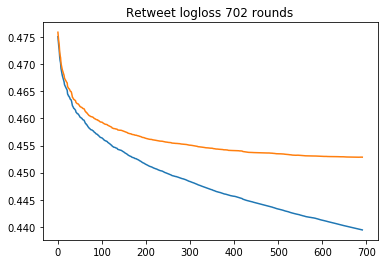

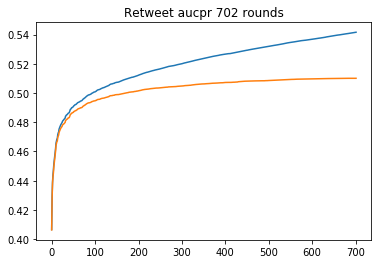

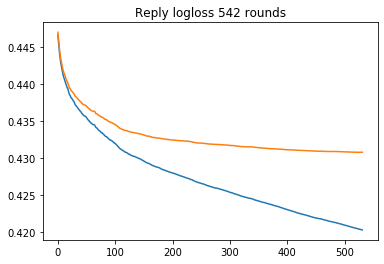

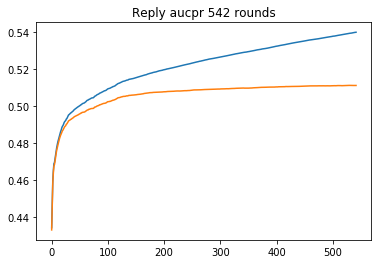

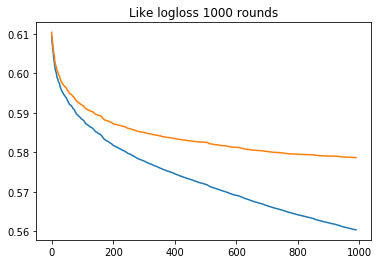

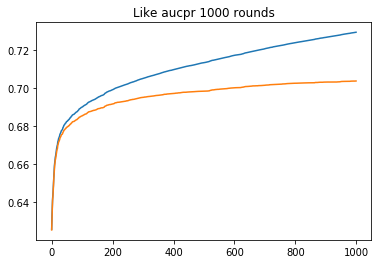

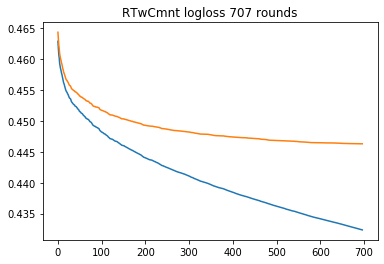

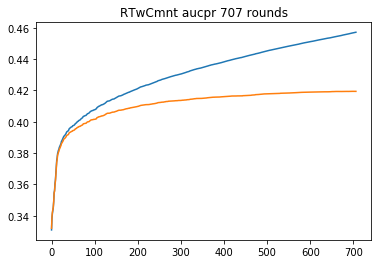

In [11]:
for tgt in tgt2evalres:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

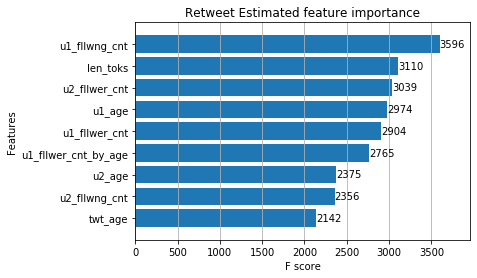

Retweet


,0,1
16,u1_fllwng_cnt,3596
7,len_toks,3110
1,u2_fllwer_cnt,3039
19,u1_age,2974
6,u1_fllwer_cnt,2904
11,u1_fllwer_cnt_by_age,2765
13,u2_age,2375
9,u2_fllwng_cnt,2356
25,twt_age,2142
20,u1_fllwng_cnt_by_age,2054


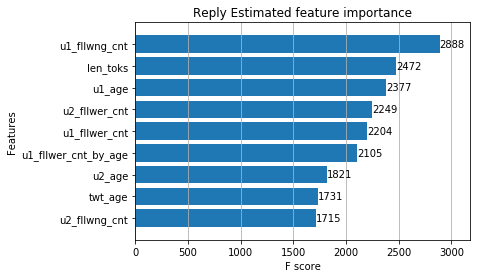

Reply


,0,1
9,u1_fllwng_cnt,2888
22,len_toks,2472
18,u1_age,2377
14,u2_fllwer_cnt,2249
7,u1_fllwer_cnt,2204
13,u1_fllwer_cnt_by_age,2105
2,u2_age,1821
24,twt_age,1731
3,u2_fllwng_cnt,1715
4,u1_fllwng_cnt_by_age,1611


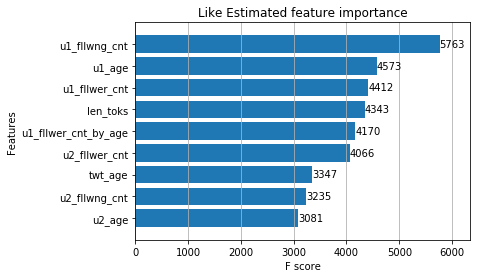

Like


,0,1
11,u1_fllwng_cnt,5763
6,u1_age,4573
12,u1_fllwer_cnt,4412
3,len_toks,4343
4,u1_fllwer_cnt_by_age,4170
10,u2_fllwer_cnt,4066
19,twt_age,3347
23,u2_fllwng_cnt,3235
8,u2_age,3081
2,u1_fllwng_cnt_by_age,2926


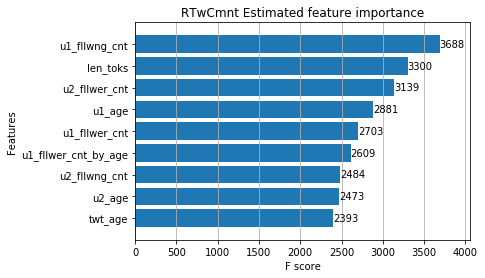

RTwCmnt


,0,1
15,u1_fllwng_cnt,3688
4,len_toks,3300
0,u2_fllwer_cnt,3139
11,u1_age,2881
21,u1_fllwer_cnt,2703
10,u1_fllwer_cnt_by_age,2609
19,u2_fllwng_cnt,2484
2,u2_age,2473
29,twt_age,2393
27,u1_fllwng_cnt_by_age,2117


In [12]:
def show_feat_importance(tgt):
    bst=tgt2bst[tgt]
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), 
                          feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgt2bst:
    show_feat_importance(tgt)

In [13]:
tgt2auc_tr={}
tgt2rce_tr={}
tgt2auc_vl={}
tgt2rce_vl={}
for tgt in tgt2bst:
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_auc_tr=compute_prauc(prdtr_i, ytr_i)
    scr_rce_tr=compute_rce(prdtr_i, ytr_i)
    scr_auc_vl=compute_prauc(prdvl_i, yvl_i)
    scr_rce_vl=compute_rce(prdvl_i, yvl_i)

    tgt2auc_tr[tgt]=scr_auc_tr
    tgt2rce_tr[tgt]=scr_rce_tr
    tgt2auc_vl[tgt]=scr_auc_vl
    tgt2rce_vl[tgt]=scr_rce_vl
    
    print('tr prauc:', f'{scr_auc_tr:.4f}','tr rce:', f'{scr_rce_tr:.4f}', )
    print('vl prauc:', f'{scr_auc_vl:.4f}','vl rce:', f'{scr_rce_vl:.4f}', )

Retweet
tr prauc: 0.5411 tr rce: 17.7623
vl prauc: 0.5101 vl rce: 15.3568
Reply
tr prauc: 0.5393 tr rce: 20.1290
vl prauc: 0.5111 vl rce: 18.1521
Like
tr prauc: 0.7292 tr rce: 18.2790
vl prauc: 0.7036 vl rce: 15.6196
RTwCmnt
tr prauc: 0.4566 tr rce: 14.1198
vl prauc: 0.4194 vl rce: 11.6220


In [14]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttr+=[(f'PRAUC {tgt}',tgt2auc_tr[tgt]),
          (f'RCE {tgt}',tgt2rce_tr[tgt])]
    lstvl+=[(f'PRAUC {tgt}',tgt2auc_vl[tgt]),
          (f'RCE {tgt}',tgt2rce_vl[tgt])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.541135,17.7623,0.539271,20.129,0.72924,18.279,0.456621,14.1198
scrvl,0.51008,15.3568,0.511143,18.1521,0.703588,15.6196,0.419418,11.622


## valid

In [15]:
# tgt=tgts[1]
# tgtcol=tgt2col[tgt]
# bst=tgt2bst[tgt]

# dvalid=xgb.DMatrix(dfvalid[cols_feat], label=dfvalid[tgtcol], feature_names=cols_feat)

# prdvalid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)

# pops=tgt2pops[tgt]

# prdvalid[:10]
# # array([0.11734424, 0.09971393, 0.05619054, 0.03059793, 0.07979691,
# #        0.01358252, 0.05293725, 0.27954698, 0.05738379, 0.01741553],
# #       dtype=float32)


# pops
# # {'train_pop': 4000000,
# #  'target_pop': 109752,
# #  'sampled_train_pop': 1000000,
# #  'sampled_target_pop': 109752}

# prdvalid_calib = calibration(prdvalid, **pops)

# prdvalid_calib[:10]
# # array([0.02952491, 0.02471944, 0.01344113, 0.00717127, 0.01945818,
# #        0.00314114, 0.0126298 , 0.08155248, 0.01373977, 0.00403964],
# #       dtype=float32)

In [16]:
def do_post_valid(tgt):
    tgtcol=tgt2col[tgt]
    bst=tgt2bst[tgt]
    pops=tgt2pops[tgt]
    dvalid=xgb.DMatrix(dfvalid[cols_feat], label=dfvalid[tgtcol], feature_names=cols_feat)
    prdvalid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
    prdvalid_calib = calibration(prdvalid, **pops)
    return prdvalid,prdvalid_calib

In [17]:
tgt2yvalid={tgt:dfvalid[tgt2col[tgt]] for tgt in tgts}
tgt2prdvalid={}
tgt2prdvalid_calib={}
for tgt in tgts:
    print(dtnow(), tgt)
    tgt2prdvalid[tgt],tgt2prdvalid_calib[tgt]=do_post_valid(tgt)


2020-03-24 03:19:33 Retweet
2020-03-24 03:20:42 Reply
2020-03-24 03:21:55 Like
2020-03-24 03:23:21 RTwCmnt


In [18]:
tgt2auc_valid={}
tgt2rce_valid={}
tgt2auc_valid_calib={}
tgt2rce_valid_calib={}
for tgt in tgts:
    print(dtnow(), tgt)
    prdvalid, prdvalid_calib = tgt2prdvalid[tgt], tgt2prdvalid_calib[tgt]
    yvalid = tgt2yvalid[tgt]
    scr_auc_valid=compute_prauc(prdvalid, yvalid)
    scr_rce_valid=compute_rce(prdvalid, yvalid)
    scr_auc_valid_calib=compute_prauc(prdvalid_calib, yvalid)
    scr_rce_valid_calib=compute_rce(prdvalid_calib, yvalid)

    tgt2auc_valid[tgt]=scr_auc_valid
    tgt2rce_valid[tgt]=scr_rce_valid
    tgt2auc_valid_calib[tgt]=scr_auc_valid_calib
    tgt2rce_valid_calib[tgt]=scr_rce_valid_calib

2020-03-24 03:24:32 Retweet
2020-03-24 03:24:44 Reply
2020-03-24 03:24:55 Like
2020-03-24 03:25:08 RTwCmnt


In [19]:
for tgt in tgts:
    print(tgt)
    print('tr          prauc:', f'{tgt2auc_tr[tgt]:.4f}','tr rce:', f'{tgt2rce_tr[tgt]:.4f}', )
    print('vl          prauc:', f'{tgt2auc_vl[tgt]:.4f}','tr rce:', f'{tgt2rce_vl[tgt]:.4f}', )
    print('valid       prauc:', f'{tgt2auc_valid[tgt]:.4f}','tr rce:', f'{tgt2rce_valid[tgt]:.4f}', )
    print('valid_calib prauc:', f'{tgt2auc_valid_calib[tgt]:.4f}','tr rce:', f'{tgt2rce_valid_calib[tgt]:.4f}', )
    

Retweet
tr          prauc: 0.5411 tr rce: 17.7623
vl          prauc: 0.5101 tr rce: 15.3568
valid       prauc: 0.3367 tr rce: 3.6044
valid_calib prauc: 0.3367 tr rce: 13.8002
Reply
tr          prauc: 0.5393 tr rce: 20.1290
vl          prauc: 0.5111 tr rce: 18.1521
valid       prauc: 0.1105 tr rce: -93.9900
valid_calib prauc: 0.1105 tr rce: 12.5042
Like
tr          prauc: 0.7292 tr rce: 18.2790
vl          prauc: 0.7036 tr rce: 15.6196
valid       prauc: 0.7032 tr rce: 15.6458
valid_calib prauc: 0.7032 tr rce: 15.6458
RTwCmnt
tr          prauc: 0.4566 tr rce: 14.1198
vl          prauc: 0.4194 tr rce: 11.6220
valid       prauc: 0.0272 tr rce: -381.5617
valid_calib prauc: 0.0272 tr rce: 6.5097


In [20]:
lsttr=[]
lstvl=[]
lstvalid=[]
lstvalid_calib=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttr+=[(f'PRAUC {tgt}',tgt2auc_tr[tgt]),
          (f'RCE {tgt}',tgt2rce_tr[tgt])]
    lstvl+=[(f'PRAUC {tgt}',tgt2auc_vl[tgt]),
          (f'RCE {tgt}',tgt2rce_vl[tgt])]
    lstvalid+=[(f'PRAUC {tgt}',tgt2auc_valid[tgt]),
          (f'RCE {tgt}',tgt2rce_valid[tgt])]
    lstvalid_calib+=[(f'PRAUC {tgt}',tgt2auc_valid_calib[tgt]),
          (f'RCE {tgt}',tgt2rce_valid_calib[tgt])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscrvalid=pd.DataFrame(lstvalid)
dfscrvalid.columns=['metric','scr']
dfscrvalid_calib=pd.DataFrame(lstvalid_calib)
dfscrvalid_calib.columns=['metric','scr']

dfscr = reduce(lambda df1,df2: pd.merge(df1,df2,on='metric'), 
            [dfscrtr,dfscrvl,dfscrvalid,dfscrvalid_calib])

dfscr.columns=['scr','tr','vl','valid','valid_calib']
dfscr.T

,0,1,2,3,4,5,6,7
scr,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
tr,0.541135,17.7623,0.539271,20.129,0.72924,18.279,0.456621,14.1198
vl,0.51008,15.3568,0.511143,18.1521,0.703588,15.6196,0.419418,11.622
valid,0.336655,3.60443,0.110503,-93.99,0.703212,15.6458,0.0272367,-381.562
valid_calib,0.336655,13.8002,0.110503,12.5042,0.703212,15.6458,0.0272367,6.50966


# infer

In [21]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 35s, sys: 15.7 s, total: 1min 51s
Wall time: 1min 52s


In [22]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 1min 56s, sys: 15.2 s, total: 2min 11s
Wall time: 2min 11s


In [23]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    pops=tgt2pops[tgt]
    prdtst = bst.predict(dtst, ntree_limit=bst.best_ntree_limit)
    prdtst_calib = calibration(prdtst, **pops)
    tgt2prdtst[tgt] = prdtst_calib

2020-03-24 03:31:51 Retweet
2020-03-24 03:33:09 Reply
2020-03-24 03:33:44 Like
2020-03-24 03:34:51 RTwCmnt
CPU times: user 1h 26min 27s, sys: 4min 54s, total: 1h 31min 21s
Wall time: 6min 7s


In [24]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [25]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-24 03:35:36 Retweet
2020-03-24 03:36:37 Reply
2020-03-24 03:37:37 RTwCmnt
2020-03-24 03:38:38 Like
CPU times: user 3min 41s, sys: 17 s, total: 3min 58s
Wall time: 4min
